In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12

In [ ]:
import transformers
print(transformers.__version__)


4.51.3


In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets import load_from_disk, DatasetDict
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
import evaluate

In [ ]:
# Optional: check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
save_path = '/content/drive/MyDrive/Multi_Modal/Project/input_full'

from datasets import load_from_disk
# Load the dataset from the saved path
ds = load_from_disk(save_path)['train']  # returns just a Dataset

print(ds)

Dataset({
    features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512'],
    num_rows: 84013
})


In [ ]:
ds = ds.class_encode_column("style")

In [ ]:
# Split the dataset
ds = ds.shuffle(seed=42)
ds = ds.train_test_split(test_size=0.3, seed=76)
val_test_split = ds["test"].train_test_split(test_size=0.5, seed=67)

final_ds = DatasetDict({
    "train": ds["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"]
})

In [ ]:
final_ds['train'].shape

(58809, 9)

In [ ]:
# facebook/deit-small-patch16-224

In [ ]:
# Image transform using processor
processor = AutoImageProcessor.from_pretrained("facebook/deit-small-patch16-224")

def transform(example):
    # Use Hugging Face processor, which handles resizing etc.
    example["pixel_values"] = processor(example["image"], return_tensors="pt")["pixel_values"].squeeze(0)
    return example

final_ds = final_ds.with_transform(transform)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["style"] for x in batch])  # Class-encoded already
    return {"pixel_values": pixel_values, "labels": labels}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# Prepare label mappings
style_names = final_ds['train'].features['style'].names
id2label = {i: name for i, name in enumerate(style_names)}
label2id = {name: i for i, name in enumerate(style_names)}

In [ ]:
# Load model (ignore mismatched head shape)

model = AutoModelForImageClassification.from_pretrained(
    "facebook/deit-small-patch16-224",
    num_labels=len(style_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([24, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./deit-wikiart",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    do_eval=True,
    logging_steps=20,
    logging_dir="./logs",
    report_to="tensorboard",
    num_train_epochs=7,
    save_total_limit=1,
    remove_unused_columns=False
)


In [ ]:
# Accuracy metric
accuracy = evaluate.load("accuracy")
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return accuracy.compute(predictions=preds, references=p.label_ids)


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_ds["train"],
    eval_dataset=final_ds["validation"],
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-18-169cf8028c40>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,2.908900
40,2.594100
60,2.459600
80,2.325500
100,2.196500
120,2.172100
140,2.101900
160,2.110800
180,2.050700
200,1.968900


TrainOutput(global_step=12866, training_loss=0.49198201351103293, metrics={'train_runtime': 5376.8568, 'train_samples_per_second': 76.562, 'train_steps_per_second': 2.393, 'total_flos': 8.058747695841755e+18, 'train_loss': 0.49198201351103293, 'epoch': 7.0})

In [ ]:
# Final test accuracy
test_results = trainer.evaluate(final_ds["test"])
print("✅ Test Accuracy:", test_results["eval_accuracy"])

✅ Test Accuracy: 0.5999841295032534


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs


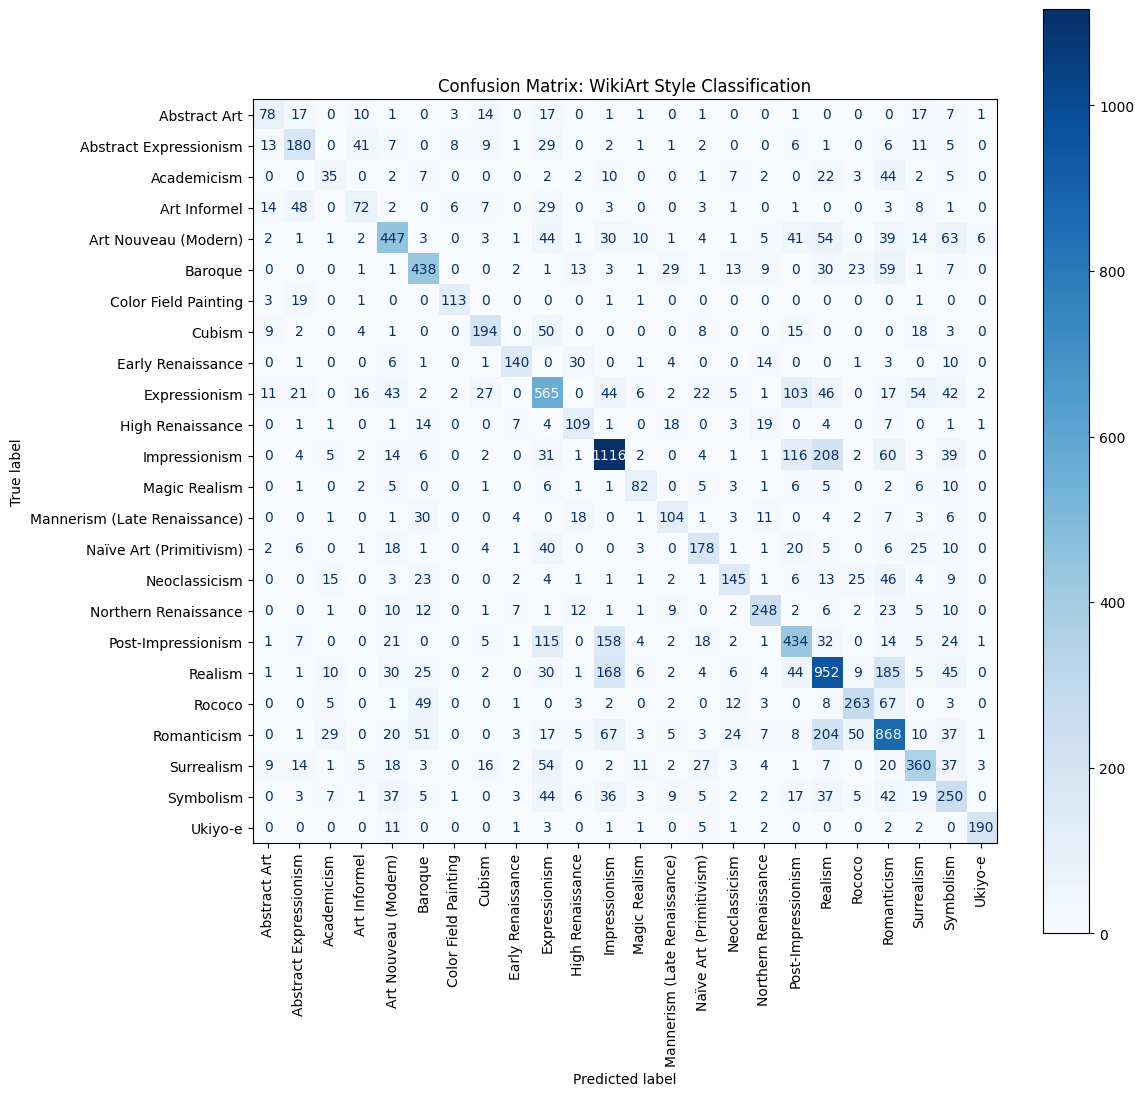

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Predict on test set
predictions = trainer.predict(final_ds["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

# Confusion matrix with labels
labels = [final_ds["test"].features["style"].int2str(i) for i in range(len(style_names))]
cm = confusion_matrix(y_true, y_pred)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, ax=ax, cmap='Blues')
plt.title("Confusion Matrix: WikiArt Style Classification")
plt.show()
